# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

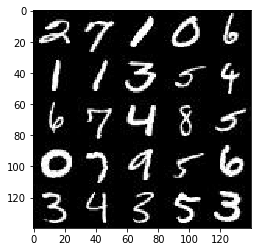

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

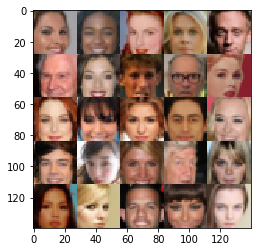

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder( tf.float32, shape=(None, image_width, image_height, image_channels) )
    input_z = tf.placeholder( tf.float32, shape=(None, z_dim))
    lr = tf.placeholder( tf.float32 )    
    
    return input_images, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [71]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """  

    with tf.variable_scope('discriminator', reuse=reuse):
       alpha = 0.2
       # Input layer is 28x28x3
       x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='valid')
       relu1 = tf.maximum(alpha * x1, x1)
       # 24x24x32
                
       x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
       bn2 = tf.layers.batch_normalization(x2, training=True)
       relu2 = tf.maximum(alpha * bn2, bn2)
       # 12x12x64
           
       x3 = tf.layers.conv2d(relu1, 256, 5, strides=3, padding='same')
       bn3 = tf.layers.batch_normalization(x3, training=True)
       relu3 = tf.maximum(alpha * bn3, bn3)
       # 4x4x256
    
       # Flatten it
       flat = tf.reshape(relu3, (-1, 4*4*256))
       logits = tf.layers.dense(flat, 1)
       out = tf.sigmoid(logits)
       
       return out, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256
              
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=3, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 12x12x64
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 24x24x32
               
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='valid')
        # 28x28x3 now
               
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [73]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [74]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [75]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [76]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    tf.reset_default_graph()
        
    input_images, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0274... Generator Loss: 4.8357


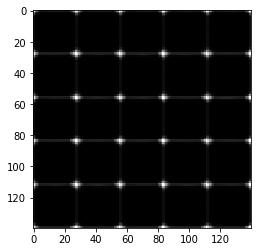

Epoch 1/2... Discriminator Loss: 0.2188... Generator Loss: 2.2453


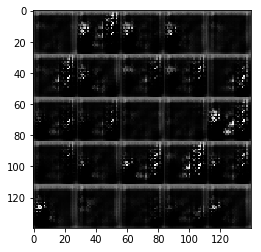

Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 4.3773


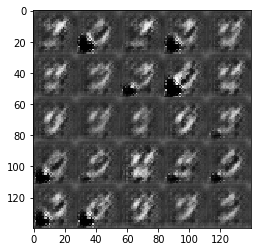

Epoch 1/2... Discriminator Loss: 0.2930... Generator Loss: 4.0026


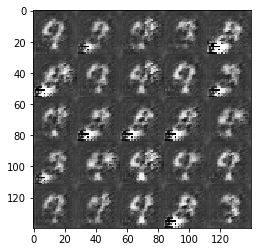

Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 1.5222


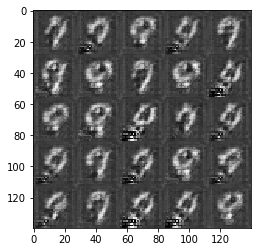

Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.6793


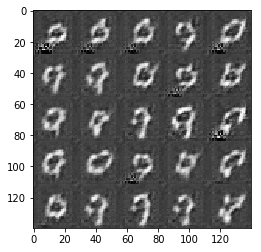

Epoch 1/2... Discriminator Loss: 1.6715... Generator Loss: 0.2919


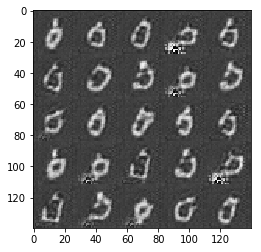

Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 2.4323


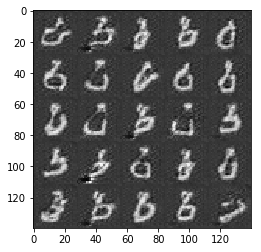

Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.5572


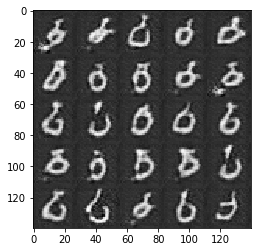

Epoch 1/2... Discriminator Loss: 0.5089... Generator Loss: 1.4544


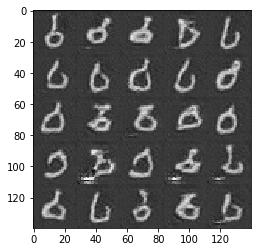

Epoch 1/2... Discriminator Loss: 0.5855... Generator Loss: 2.1034


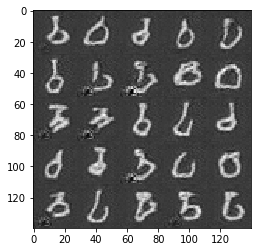

Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 0.7938


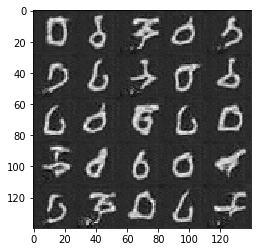

Epoch 1/2... Discriminator Loss: 0.7739... Generator Loss: 1.4231


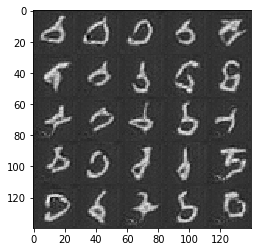

Epoch 1/2... Discriminator Loss: 0.5772... Generator Loss: 1.3816


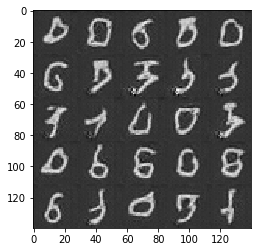

Epoch 1/2... Discriminator Loss: 0.5253... Generator Loss: 1.5149


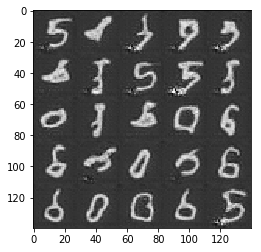

Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 2.6694


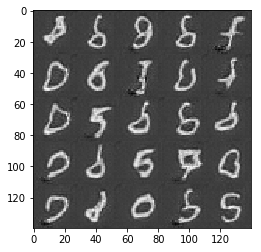

Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 1.2592


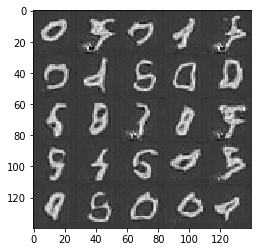

Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.4079


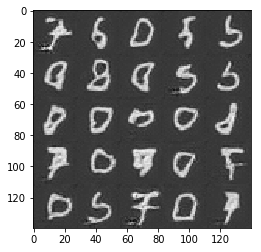

Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.4026


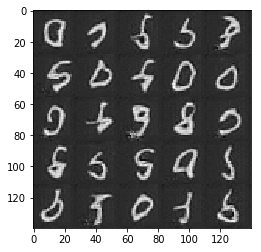

Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 1.1045


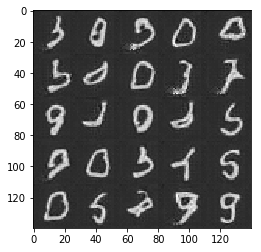

Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.4082


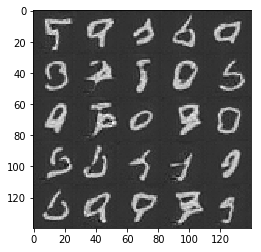

Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.6100


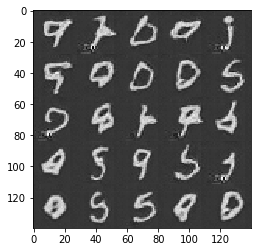

Epoch 2/2... Discriminator Loss: 0.4873... Generator Loss: 1.4904


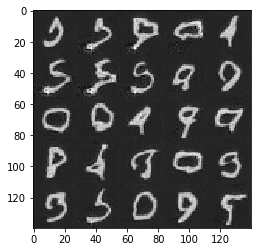

Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.8201


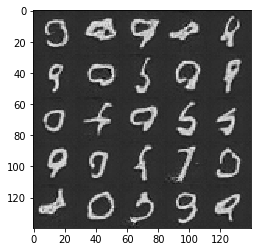

Epoch 2/2... Discriminator Loss: 0.6585... Generator Loss: 1.7634


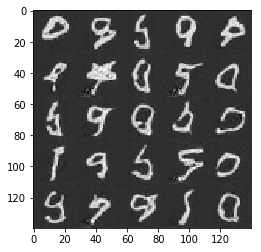

Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 0.9136


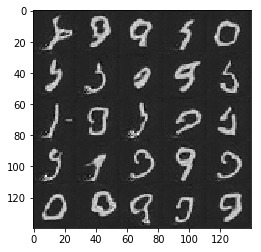

Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 1.1269


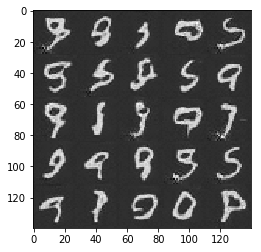

Epoch 2/2... Discriminator Loss: 0.6004... Generator Loss: 1.6067


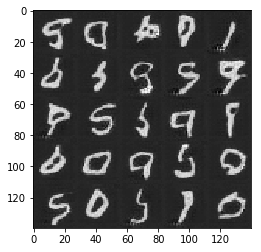

Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.2317


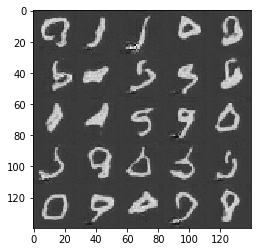

Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.8367


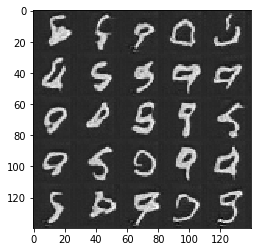

Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 2.1453


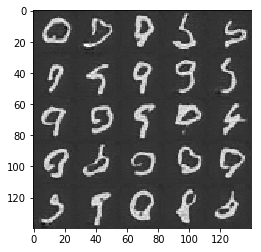

Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 2.2563


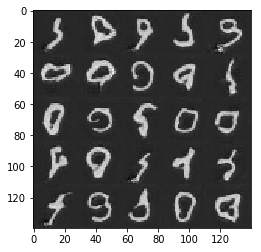

Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.5305


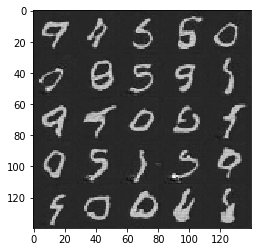

Epoch 2/2... Discriminator Loss: 1.2445... Generator Loss: 0.5223


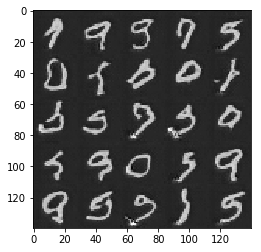

Epoch 2/2... Discriminator Loss: 0.6393... Generator Loss: 2.2181


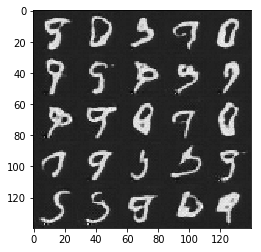

Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 4.6117


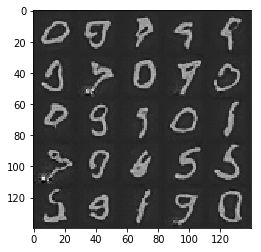

Epoch 2/2... Discriminator Loss: 1.4593... Generator Loss: 0.4493


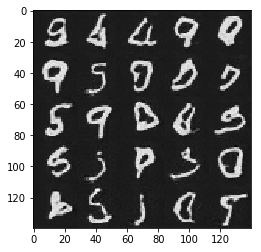

IndexError: list index out of range

In [78]:
batch_size = 32
z_dim = 10
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 4.1779


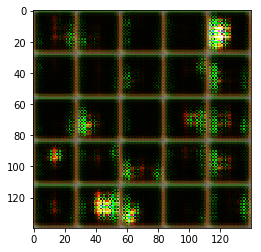

Epoch 1/1... Discriminator Loss: 0.1074... Generator Loss: 2.9691


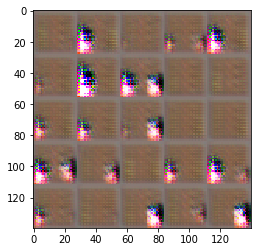

Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 1.9403


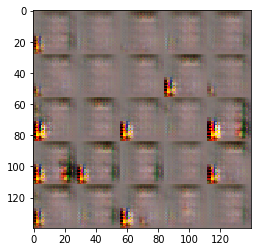

Epoch 1/1... Discriminator Loss: 1.6924... Generator Loss: 0.5471


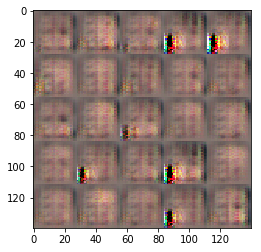

Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.2906


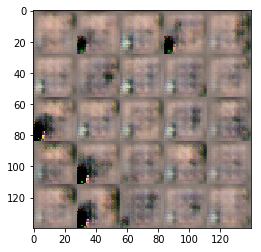

Epoch 1/1... Discriminator Loss: 0.2615... Generator Loss: 2.4416


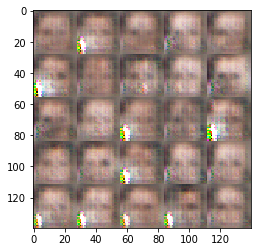

Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 1.3464


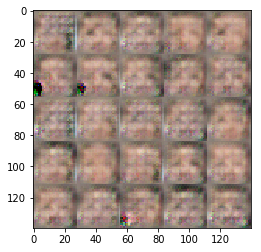

Epoch 1/1... Discriminator Loss: 0.2786... Generator Loss: 11.6694


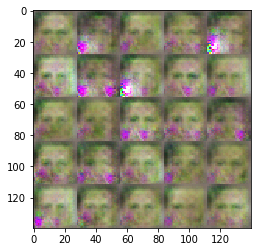

Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.6835


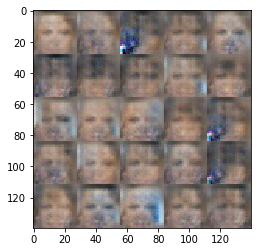

Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.0201


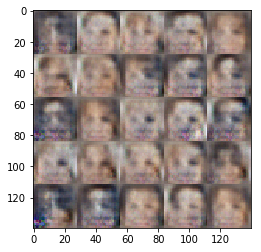

Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 2.0753


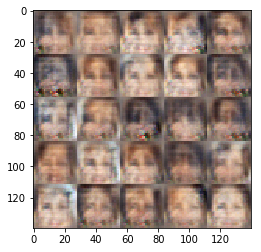

Epoch 1/1... Discriminator Loss: 0.6656... Generator Loss: 1.3302


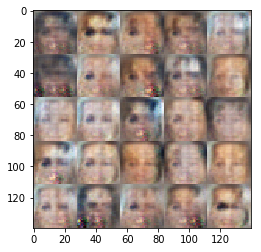

Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.4049


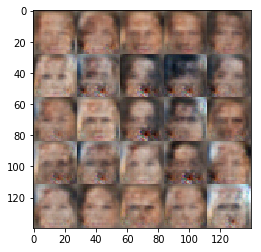

Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.0271


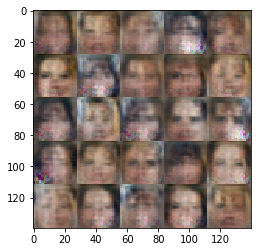

Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.4792


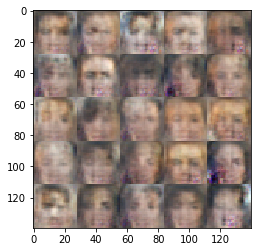

Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.7445


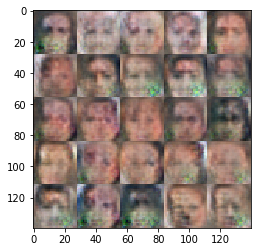

Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.7156


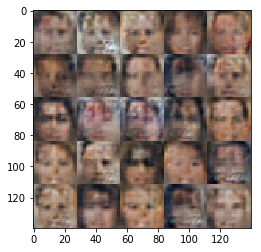

Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.4482


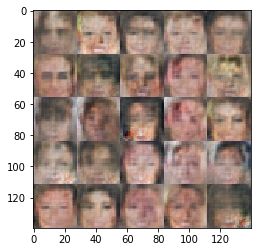

Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.0181


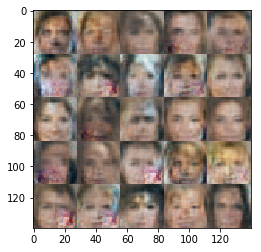

Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.3635


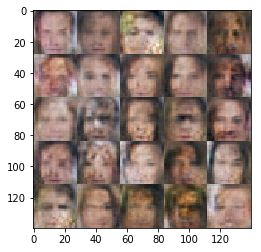

Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.3977


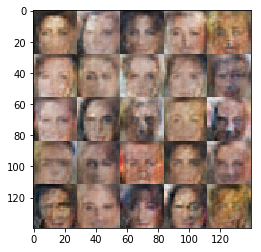

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8552


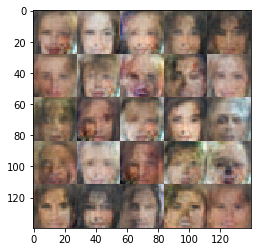

Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.1117


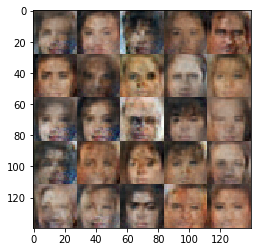

Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5207


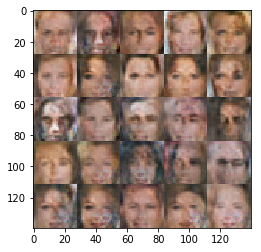

Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.0354


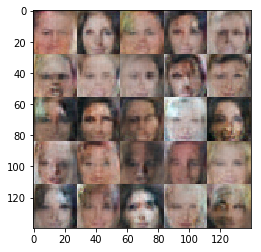

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.9761


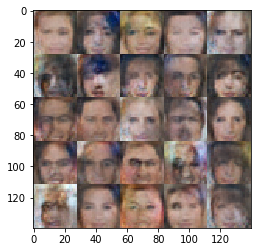

Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 1.2776


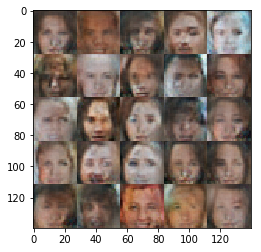

Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 1.1105


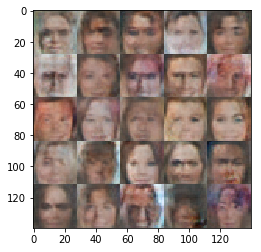

Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1074


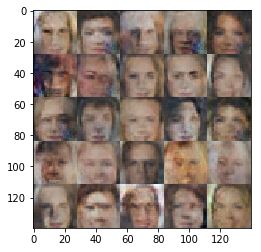

Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 1.1902


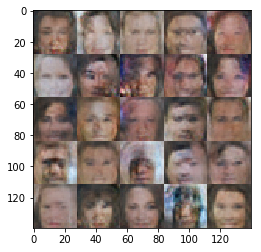

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.8002


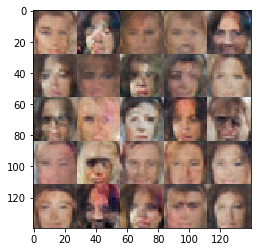

Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7904


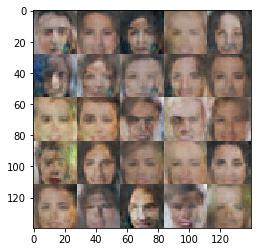

Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 1.0543


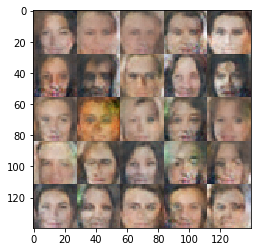

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.9862


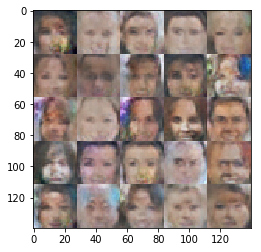

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8696


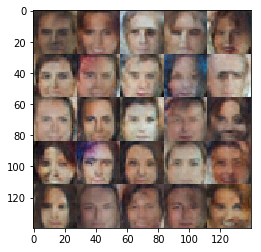

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.9344


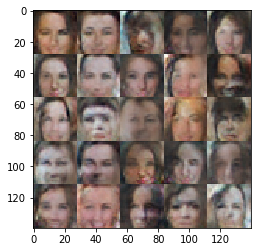

Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.7300


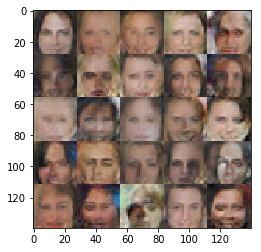

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.7026


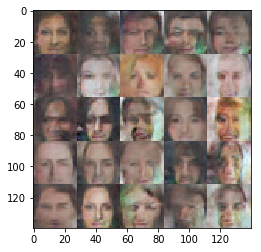

Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.9196


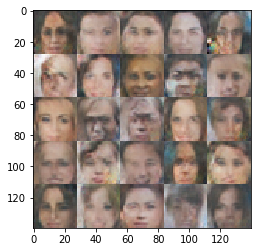

Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6998


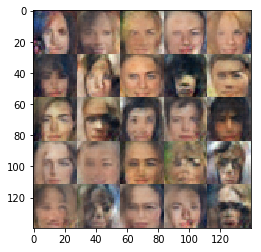

Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8465


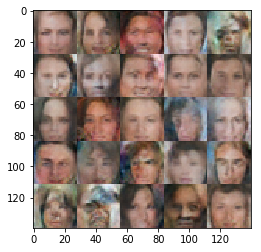

Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6294


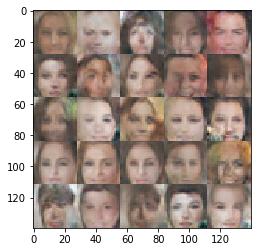

Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7159


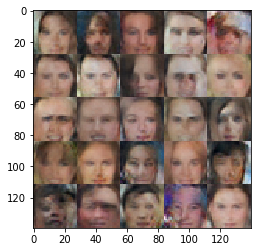

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.6912


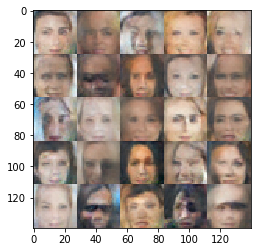

Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.8053


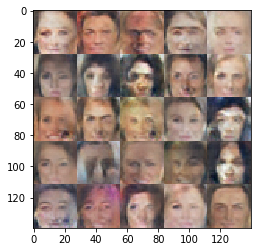

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.9353


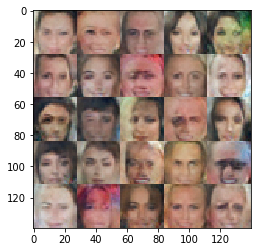

Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.0995


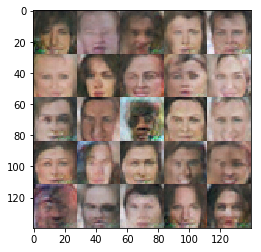

Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7511


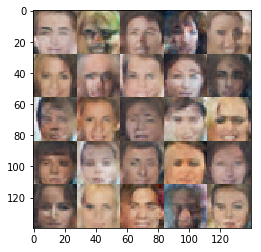

Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 0.8741


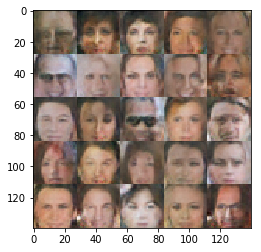

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6691


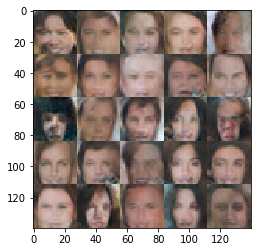

Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9369


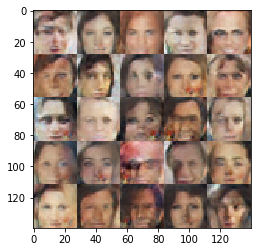

Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.7265


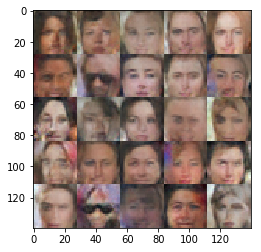

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7212


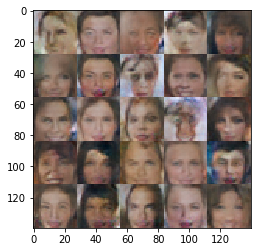

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7120


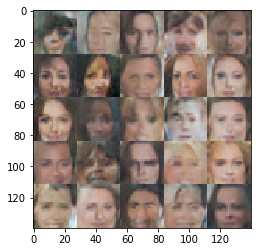

Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 0.6832


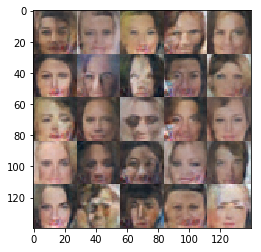

Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.8910


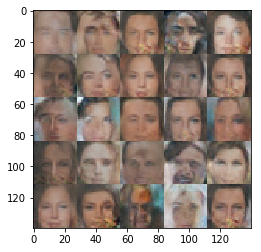

Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5580


IndexError: list index out of range

In [79]:
batch_size = 32
z_dim = 50
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.